<a href="https://colab.research.google.com/github/Shubhranshu331/Handwritten-Digit-Recognition/blob/main/Handwritten_Digit_Recognition_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'digit-recognizer:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F3004%2F861823%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240709%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240709T191617Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D200ec5f25e6118d97bef976526607636d87889ad8a4229c0e2391b3eeb6f5b3bdb93ee861594a4ca1ae339ac89c4d718e466b35afd1fa94d0e40b31969a40c23b2e07039341e8aaa635236078d3b4f6982d71c5aecf787c9eedcc09487e5ce8fe460f9b7a21f8ab7f16be3f0e7867fa181b967dfd92c32daa0b654e387d4f93c5d9f35b6dfee39d0b4c36527022f07e5c20f7c31a790dde8eb426551645ba5b9e1a5f1b75f77b8c0800e7fec15dfe17f4f8f70b9b7baf40bb385b2e75a4654068e6505dd2a8317509b0f5333af4bb9084b68eb75cc01ca79f62e6a5b9b5846e4b831f3431838ffb1e0bbf89d047e68a63ac5ebbd6fdd50f709dec4dc4900441a'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 16054568 bytes downloaded
Downloaded and uncompressed: digit-recognizer
Data source import complete.


In [55]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import tensorflow as tf # tools for building and training neural
                        #networks,handling data, and visualizing results.
import matplotlib.pyplot as plt # provides an implicit, MATLAB-like way of creating plots.
import seaborn as sn # default styles and color palettes to create
                     # attractive statistical plots.
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import datetime
import platform # access to underlying platform information, including hardware
                # details, operating system specifics, and interpreter version data.

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [56]:
# print('Python version:', platform.python_version())
# print('Tensorflow version:', tf.__version__)
# print('Keras version:', tf.keras.__version__)

In [57]:
# load the tensorboard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [58]:
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

dimention of train and test data

In [59]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
train.info(), train.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


(None, (42000, 785))

In [61]:
test.info(), test.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


(None, (28000, 784))

In [62]:
X = train.iloc[:, 1:785]
y = train.iloc[:, 0]

X_test = test.iloc[:, 0:784]

**Visualising the data using tsne(t-distribiuted stochastic neighbour embedding)**

*Dimensionality Reduction: Imagine a dataset with hundreds or even thousands of features. t-SNE takes this high-dimensional data and transforms it into a lower-dimensional space, typically 2 or 3 dimensions, which is much easier to visualize.
*Preserving Relationships: While reducing the dimensions, t-SNE tries to maintain the relationships between the data points. Data points that were similar in the high-dimensional space will ideally be close together in the lower-dimensional visualization. This allows you to see clusters, patterns, and groupings in the data.
*Non-Linear: Unlike some dimensionality reduction methods, t-SNE is non-linear. This means it can capture more complex relationships between data points that wouldn't be possible with a linear transformation.

In [63]:
X_tsn = X/255

from sklearn.manifold import TSNE
tsne = TSNE()

tsne_res = tsne.fit_transform(X_tsn)

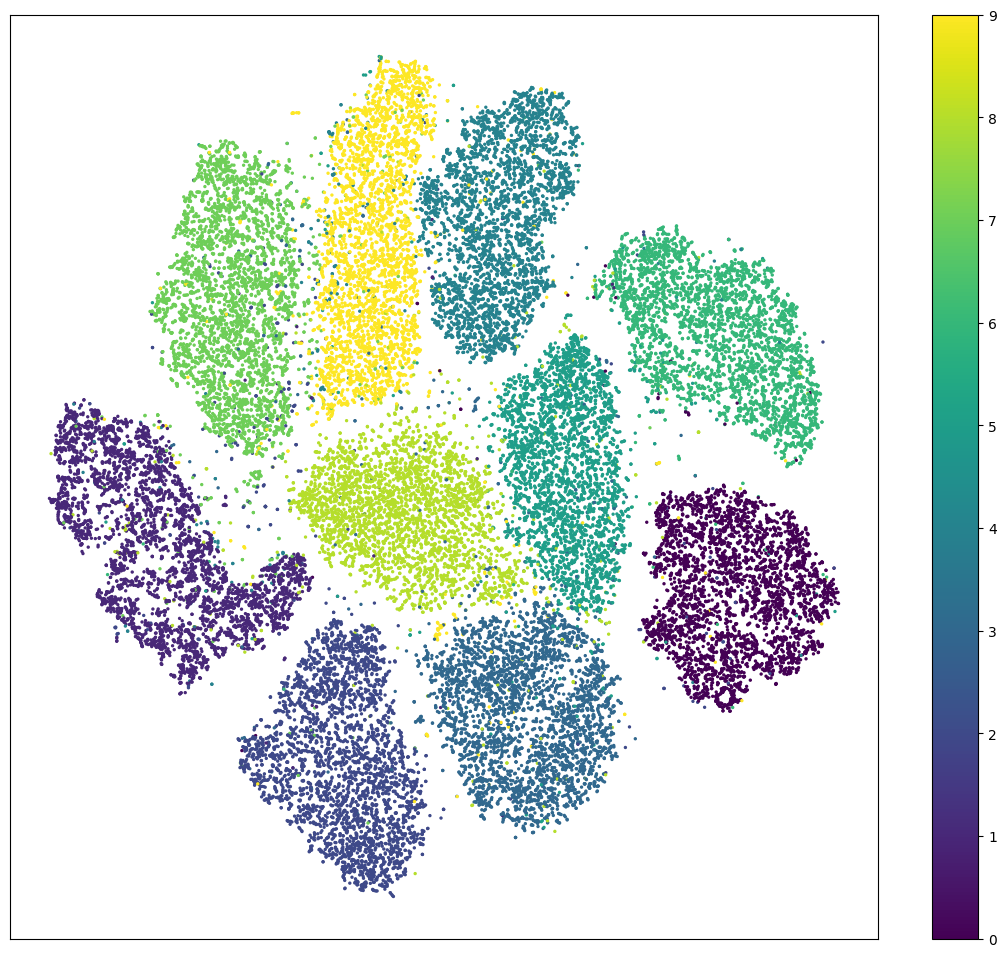

In [64]:
plt.figure(figsize = (14, 12))
plt.scatter(tsne_res[:,0], tsne_res[:,1], c=y, s=2)
plt.xticks([])
plt.yticks([])
plt.colorbar()

We are dividing our dataset (X) into two parts.

The training dataset (80%) is used to fit our models
The Validation dataset (20%) is used to evaluate our models
train_test_split() method returns us the training data, its labels and also the validation data and its labels.

In [65]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size = 0.2,
                                                                random_state = 1212)

In [66]:
# dimensions of training and testing data

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_validation: ", X_validation.shape)
print("y_validation: ", y_validation.shape)

X_train:  (33600, 784)
y_train:  (33600,)
X_validation:  (8400, 784)
y_validation:  (8400,)


In [67]:
# converting training, testing and validation data into arays

x_train_re = X_train.to_numpy().reshape(33600,28,28)
y_train_re = y_train.values
x_validation_re = X_validation.to_numpy().reshape(8400,28,28)
y_validation_re = y_validation.values
x_test_re = test.to_numpy().reshape(28000,28,28)

In [68]:
# dimensions of training testing and validation data after reshaping

print("x_train: ",x_train_re.shape)
print("y_train: ",y_train_re.shape)
print("x_validation: ",x_validation_re.shape)
print('y_validation: ',y_validation_re.shape)
print("x_test: ",x_test_re.shape)

x_train:  (33600, 28, 28)
y_train:  (33600,)
x_validation:  (8400, 28, 28)
y_validation:  (8400,)
x_test:  (28000, 28, 28)


In [69]:
# saving image parameters to the constants that we will use later for data_reshaping
#and model trainig

(_, IMAGE_WIDTH, IMAGE_HEIGHT) = x_train_re.shape
IMAGE_CHANELS = 1

print("IMAGE_WIDTH: ", IMAGE_WIDTH)
print("IMAGE_HEIGHT: ",IMAGE_HEIGHT)
print("IMAGE_CHANELS: ",IMAGE_CHANELS)

IMAGE_WIDTH:  28
IMAGE_HEIGHT:  28
IMAGE_CHANELS:  1


In [70]:
# explore the data

pd.DataFrame(x_train_re[0])

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,155,155,12,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,254,254,103,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,254,254,55,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,254,254,20,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,254,170,6,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,242,37,0,0,0,0,0,0,0,0


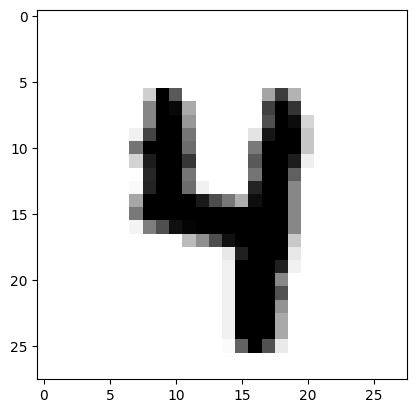

In [71]:
# visualizing how digits are written

plt.imshow(x_train_re[1], cmap=plt.cm.binary)
plt.show()

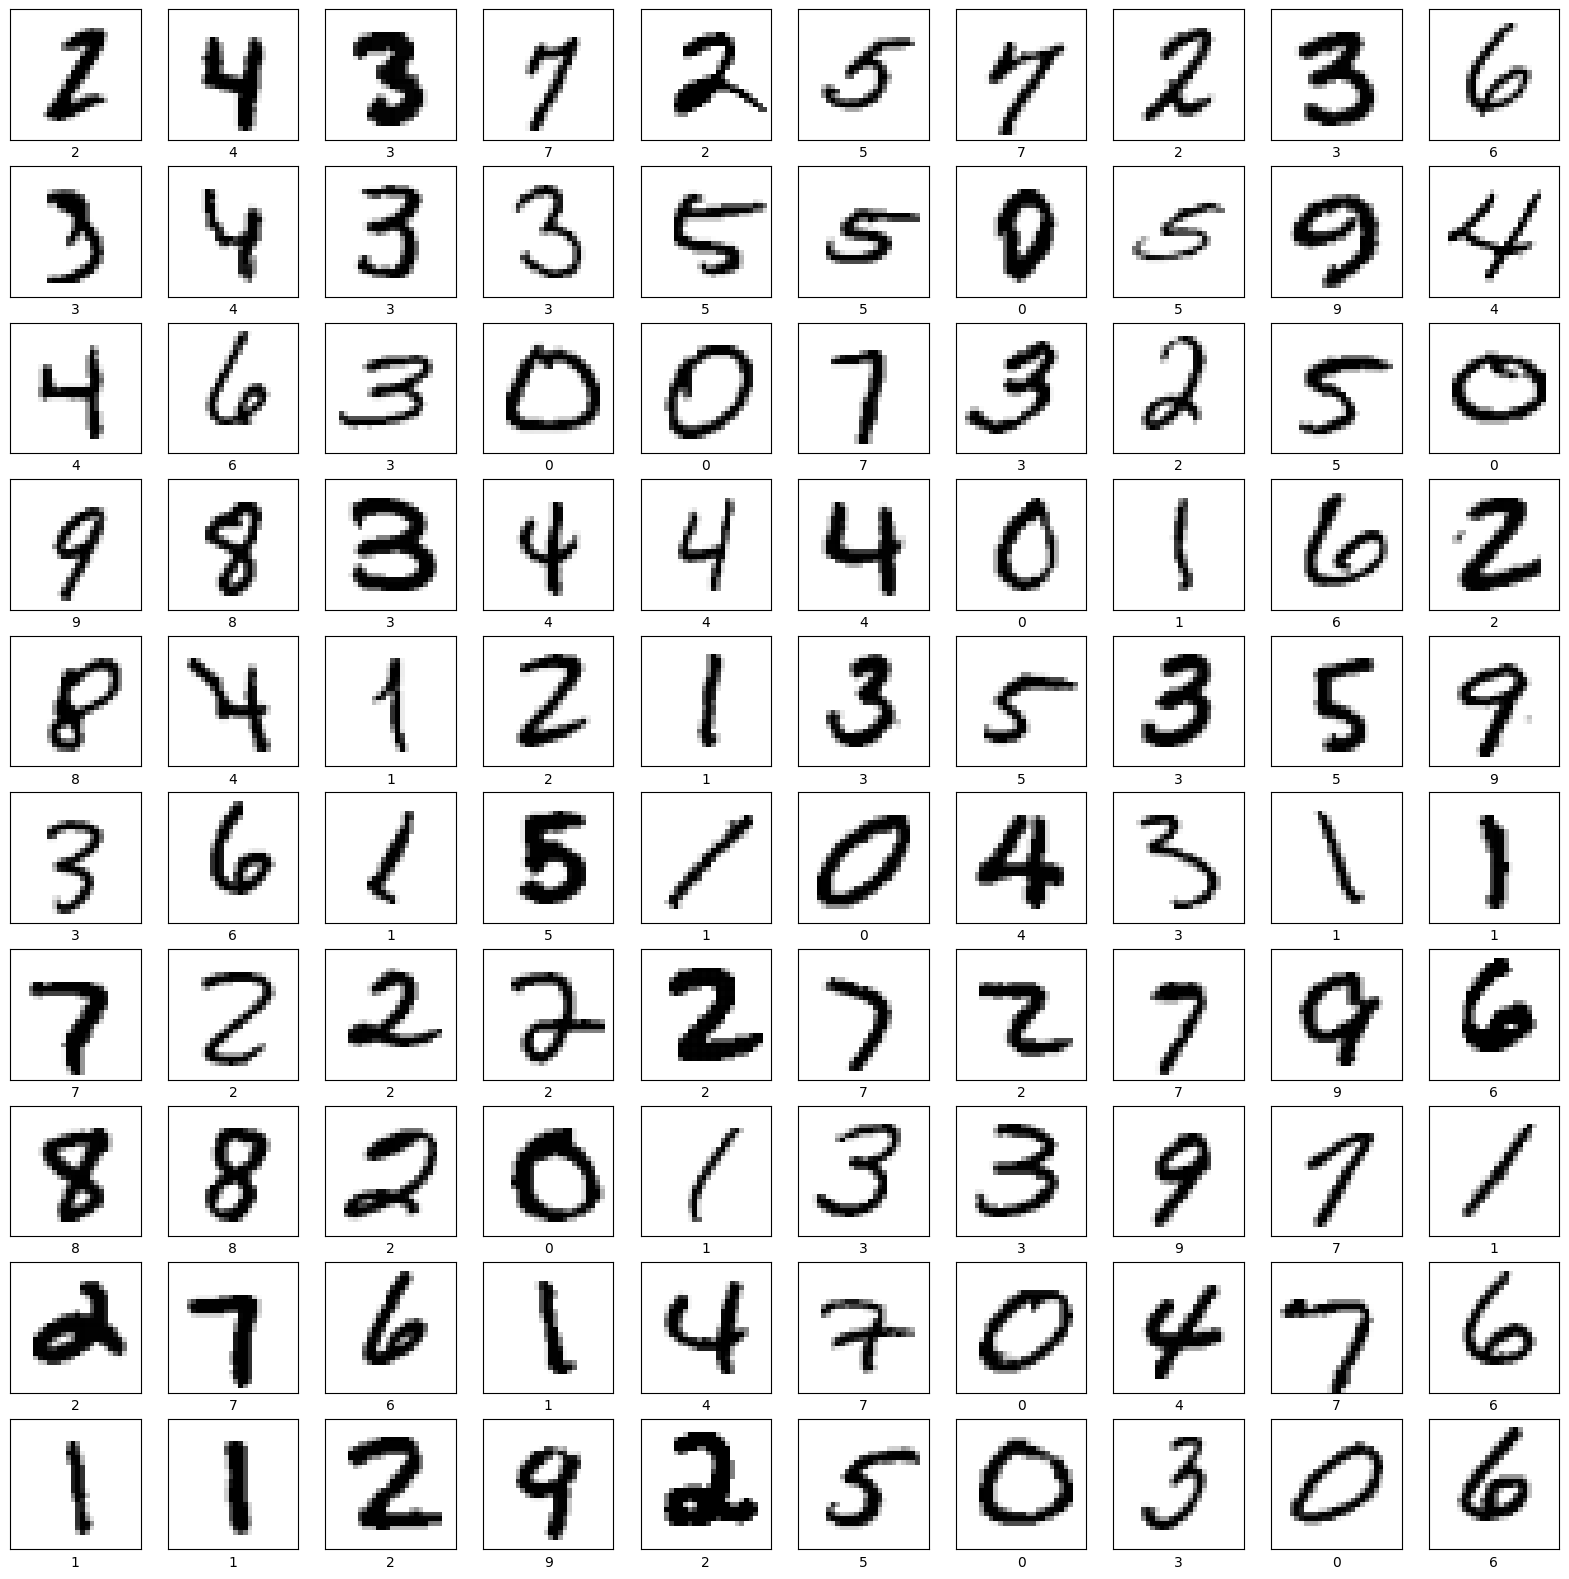

In [72]:
numbers_to_display = 100
num_cells = math.ceil(math.sqrt(numbers_to_display))
plt.figure(figsize = (20, 20))
for i in range (numbers_to_display):
    plt.subplot(num_cells, num_cells, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train_re[i], cmap = plt.cm.binary)
    plt.xlabel(y_train_re[i])

In [73]:
# reshaping test, validation and train data

x_train_with_chanels = x_train_re.reshape(
    x_train_re.shape[0],
    IMAGE_WIDTH,
    IMAGE_HEIGHT,
    IMAGE_CHANELS
)
x_validation_with_chanels = x_validation_re.reshape(
    x_validation_re.shape[0],
    IMAGE_WIDTH,
    IMAGE_HEIGHT,
    IMAGE_CHANELS
)
x_test_with_chanels = x_test_re.reshape(
    x_test_re.shape[0],
    IMAGE_WIDTH,
    IMAGE_HEIGHT,
    IMAGE_CHANELS
)

In [74]:
print('x_train_with_chanels:', x_train_with_chanels.shape)
print('x_validation_with_chanels:', x_validation_with_chanels.shape)
print('x_test_with_chanels:', x_test_with_chanels.shape)

x_train_with_chanels: (33600, 28, 28, 1)
x_validation_with_chanels: (8400, 28, 28, 1)
x_test_with_chanels: (28000, 28, 28, 1)


In [75]:
# normalise train, test and validation data

x_train_normalized = x_train_with_chanels / 255
x_validation_normalized = x_validation_with_chanels /255
x_test_normalized = x_test_with_chanels /255

In [76]:
# Let's check just one row from the 0th image to see color chanel values
# after normalization.
x_train_normalized[0][10]

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.02352941],
       [0.99607843],
       [0.99607843],
       [0.99607843],
       [0.76862745],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ]])

**building the cnn model to classify the handwritten digits**

A Convolutional Neural Network model generally consists of convolutional and pooling layers. using Sequential Keras model which have two pairs of Convolution2D and MaxPooling2D layers. The MaxPooling layer acts as a sort of downsampling using max values in a region instead of averaging.

In [77]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Convolution2D(
    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANELS),
    kernel_size=5,
    filters=8,
    strides=1,
    activation=tf.keras.activations.relu,
    kernel_initializer=tf.keras.initializers.VarianceScaling()
))

model.add(tf.keras.layers.MaxPooling2D(
    pool_size = (2, 2),
    strides = (2, 2)
))

model.add(tf.keras.layers.Convolution2D(
    kernel_size = 5,
    filters = 16,
    strides = 1,
    activation = tf.keras.activations.relu,
    kernel_initializer = tf.keras.initializers.VarianceScaling()
))

model.add(tf.keras.layers.MaxPooling2D(
    pool_size = (2, 2),
    strides = (2, 2)
))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(
    units = 128,
    activation = tf.keras.activations.relu
))

model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(
    units = 10,
    activation = tf.keras.activations.softmax,
    kernel_initializer = tf.keras.initializers.VarianceScaling()
))

In [78]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 24, 24, 8)         208       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 12, 12, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 16)          3216      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 4, 4, 16)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)              

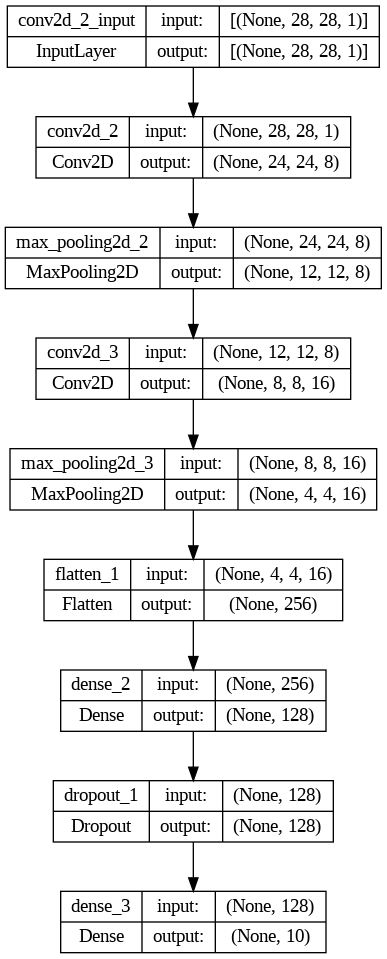

In [79]:
# visualization of the model

tf.keras.utils.plot_model(
    model,
    show_shapes =True,
    show_layer_names = True
)

In [80]:
# compiling the model now

adam_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

model.compile(
    optimizer = adam_optimizer,
    loss = tf.keras.losses.sparse_categorical_crossentropy,
    metrics = ['accuracy']
)

In [81]:
# train the  model

log_dir=".logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

training_history = model.fit(
    x_train_normalized,
    y_train_re,
    epochs=10,
    validation_data=(x_validation_normalized, y_validation_re),
    callbacks=[tensorboard_callback]
)

print("The model has successfully trained")

Epoch 1/10
1050/1050 [==============================] - 18s 16ms/step - loss: 0.2663 - accuracy: 0.9177 - val_loss: 0.0913 - val_accuracy: 0.9718
Epoch 2/10
1050/1050 [==============================] - 19s 18ms/step - loss: 0.0845 - accuracy: 0.9736 - val_loss: 0.0549 - val_accuracy: 0.9838
Epoch 3/10
1050/1050 [==============================] - 17s 16ms/step - loss: 0.0591 - accuracy: 0.9813 - val_loss: 0.0501 - val_accuracy: 0.9854
Epoch 4/10
1050/1050 [==============================] - 17s 16ms/step - loss: 0.0478 - accuracy: 0.9848 - val_loss: 0.0481 - val_accuracy: 0.9863
Epoch 5/10
1050/1050 [==============================] - 17s 16ms/step - loss: 0.0395 - accuracy: 0.9877 - val_loss: 0.0580 - val_accuracy: 0.9823
Epoch 6/10
1050/1050 [==============================] - 18s 18ms/step - loss: 0.0330 - accuracy: 0.9896 - val_loss: 0.0447 - val_accuracy: 0.9865
Epoch 7/10
1050/1050 [==============================] - 17s 16ms/step - loss: 0.0290 - accuracy: 0.9902 - val_loss: 0.0484 -

**Model Evaluation**

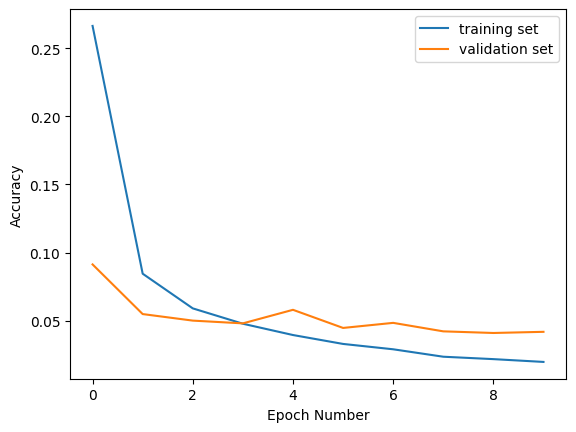

In [82]:
# loss plot curve for taining and validation

plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(training_history.history['loss'], label='training set')
plt.plot(training_history.history['val_loss'], label='validation set')
plt.legend()

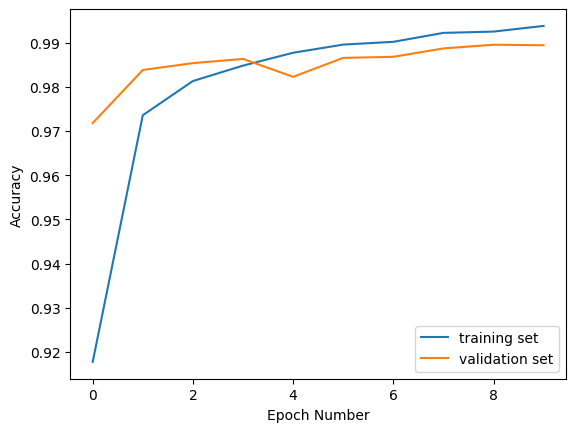

In [83]:
# Accuracy plot curve for training and validation

plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(training_history.history['accuracy'], label='training set')
plt.plot(training_history.history['val_accuracy'], label='validation set')
plt.legend()

**Performance of training dataset**

In [84]:
%%capture
train_loss, train_accuracy = model.evaluate(x_train_normalized, y_train_re)

In [85]:
print('Train loss: ', train_loss)
print('Train accuracy: ', train_accuracy)

Train loss:  0.007944965735077858
Train accuracy:  0.9977976083755493


**Performance of validation dataset**

In [86]:
%%capture
validation_loss, validation_accuracy = model.evaluate(x_validation_normalized, y_validation_re)

In [87]:
print('Train loss: ', validation_loss)
print('Train accuracy: ', validation_accuracy)

Train loss:  0.041848693042993546
Train accuracy:  0.9894047379493713


**Save and load the model**

In [88]:
model_name = 'digits_recognition_cnn.h5'
model.save(model_name, save_format='h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [89]:
loaded_model = tf.keras.models.load_model(model_name)

**Visualise validation predicted data on how the digits were written**

In [90]:
predictions_one_hot = loaded_model.predict([x_validation_normalized])

263/263 [==============================] - 1s 5ms/step


In [91]:
print('predictions_one_hot:', predictions_one_hot.shape)

predictions_one_hot: (8400, 10)


In [92]:
# Predictions in form of one-hot vectors (arrays of probabilities).
pd.DataFrame(predictions_one_hot)

,0,1,2,3,4,5,6,7,8,9
0,6.735012e-07,9.999859e-01,1.156379e-07,2.024901e-09,4.094996e-07,1.068140e-08,3.584081e-07,1.215071e-08,1.245294e-05,3.156202e-08
1,1.650436e-11,1.795862e-08,1.380944e-11,9.999998e-01,2.556697e-12,9.920075e-09,5.585216e-15,1.306388e-09,5.414243e-08,1.151655e-07
2,1.221554e-08,5.358609e-08,1.047925e-07,1.509782e-08,2.995063e-15,2.327647e-07,5.809627e-09,1.471846e-12,9.999995e-01,5.207428e-09
3,1.585815e-08,9.999973e-01,2.292699e-08,2.780548e-09,1.381033e-06,8.476365e-09,8.500705e-08,1.087387e-06,1.432195e-08,2.417678e-08
4,2.306704e-14,1.436136e-13,1.307879e-13,1.288352e-09,1.383514e-08,1.693908e-11,7.543950e-19,1.503067e-09,1.222936e-07,9.999998e-01
...,...,...,...,...,...,...,...,...,...,...
8395,3.400703e-18,2.870905e-13,1.167675e-14,4.462964e-19,9.999999e-01,6.907189e-13,9.664803e-13,2.487809e-17,1.342487e-13,2.656226e-10
8396,2.828952e-13,3.293061e-16,4.637284e-17,2.661339e-09,4.507541e-16,9.999998e-01,1.475454e-10,1.587783e-20,1.639982e-07,1.957779e-10
8397,2.751153e-15,9.004074e-12,8.225778e-15,7.743010e-16,1.301660e-10,2.388329e-15,5.457852e-16,9.999999e-01,2.461571e-13,1.122388e-09
8398,2.117071e-09,6.178669e-13,1.956687e-15,1.955066e-14,8.396084e-15,1.377889e-07,9.999998e-01,7.756026e-21,3.538010e-12,1.709959e-13


In [93]:
# Let's extract predictions with highest probabilites and detect what digits have been actually recognized.
predictions = np.argmax(predictions_one_hot, axis=1)
pd.DataFrame(predictions)

,0
0,1
1,3
2,8
3,1
4,9
...,...
8395,4
8396,5
8397,7
8398,6


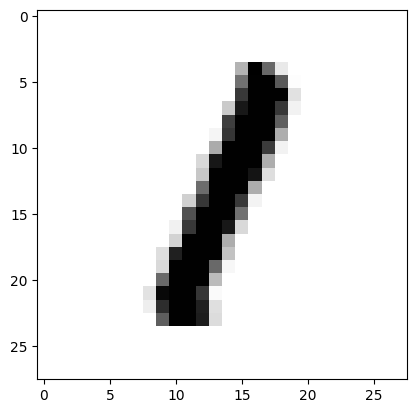

In [94]:
plt.imshow(x_validation_normalized[0].reshape((IMAGE_WIDTH, IMAGE_HEIGHT)), cmap=plt.cm.binary)
plt.show()

<ipython-input-95-6e85d9dbcc06>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(num_cells, num_cells, plot_index + 1)


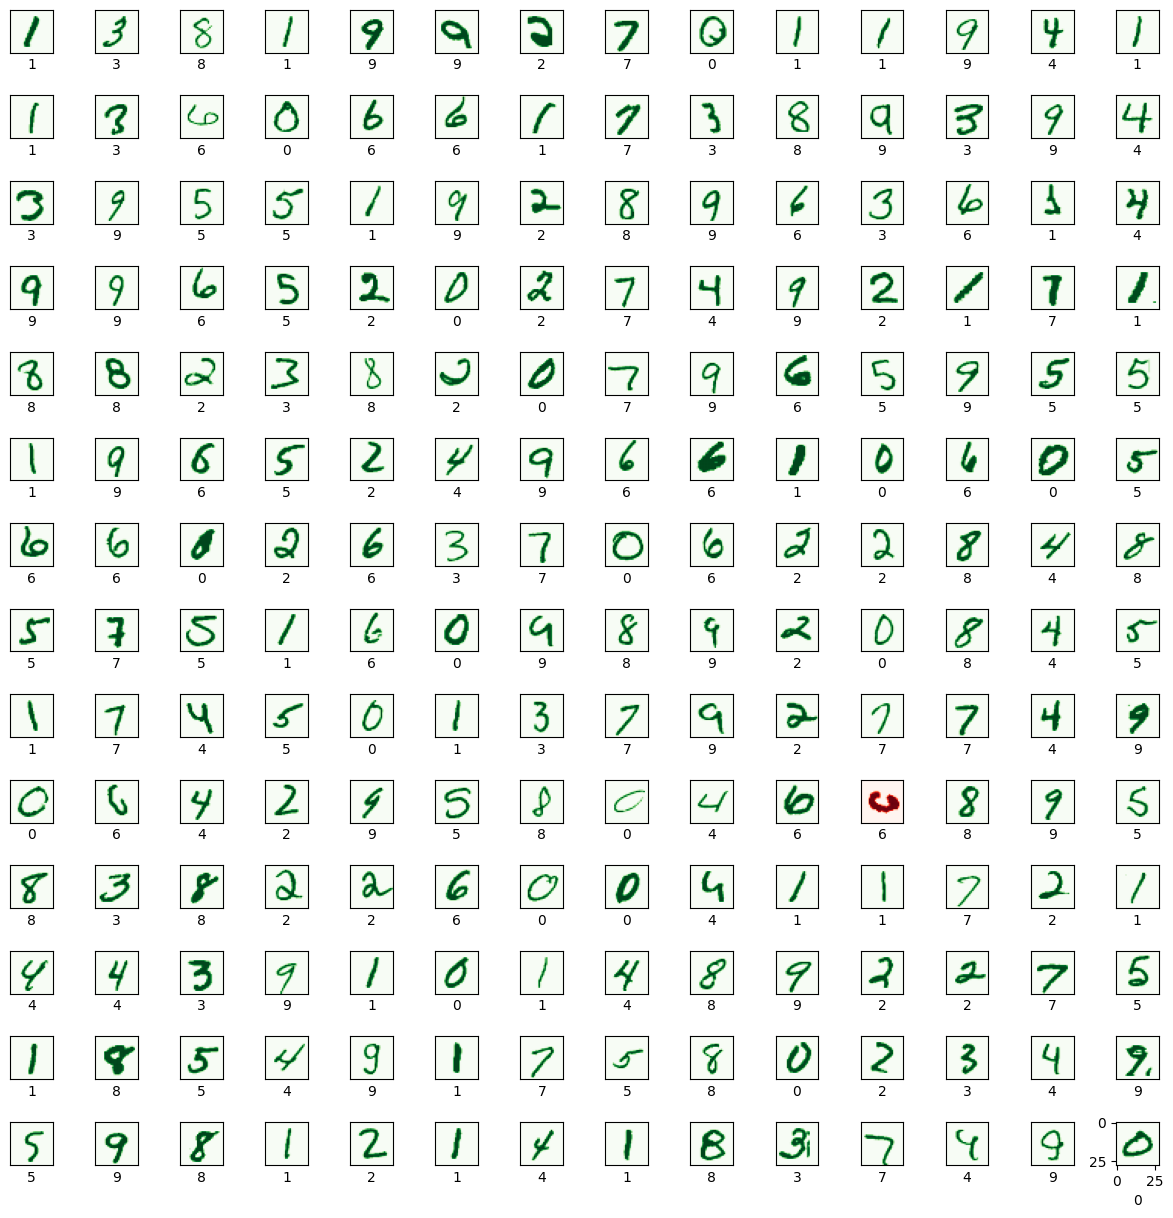

In [95]:
numbers_to_display = 196
num_cells = math.ceil(math.sqrt(numbers_to_display))
plt.figure(figsize=(15, 15))

for plot_index in range(numbers_to_display):
    predicted_label = predictions[plot_index]
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    color_map = 'Greens'if predicted_label == y_validation_re[plot_index] else 'Reds'
    plt.subplot(num_cells, num_cells, plot_index + 1)
    plt.imshow(x_validation_normalized[plot_index].reshape((IMAGE_WIDTH, IMAGE_HEIGHT)), cmap=color_map)
    plt.xlabel(predicted_label)

plt.subplots_adjust(hspace=1, wspace=0.5)
plt.show()

**Confusion matrix of validation daatset**

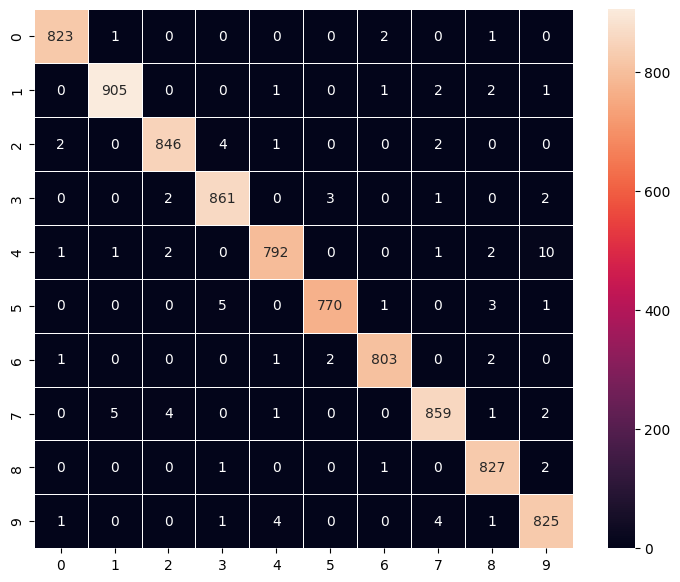

In [96]:
confusion_matrix = tf.math.confusion_matrix(y_validation_re, predictions)
f, ax = plt.subplots(figsize=(9, 7))
sn.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.5,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

**Model prediction of unseen dataset**

In [97]:
predictions_one_hot = loaded_model.predict([x_test_normalized])
print('predictions_one_hot:', predictions_one_hot.shape)

875/875 [==============================] - 4s 5ms/step
predictions_one_hot: (28000, 10)


In [98]:
pd.DataFrame(predictions_one_hot)

,0,1,2,3,4,5,6,7,8,9
0,6.993380e-10,3.343443e-14,9.999998e-01,7.080885e-08,4.644947e-11,4.932735e-15,4.547875e-14,2.848729e-11,1.035939e-08,1.189951e-10
1,9.999989e-01,3.427105e-13,2.485987e-08,1.028884e-10,4.364830e-13,1.141762e-08,6.945641e-07,3.819352e-12,1.373222e-08,2.886227e-07
2,3.001912e-10,2.569492e-08,7.537341e-10,1.977215e-06,2.525407e-05,2.328753e-08,2.962557e-13,1.522376e-07,1.068991e-05,9.999618e-01
3,3.046744e-02,1.983787e-11,6.270085e-06,6.801405e-07,1.675675e-05,1.793887e-07,3.386462e-08,2.719226e-08,8.460612e-05,9.694239e-01
4,4.196101e-12,2.366566e-09,5.510982e-08,9.999999e-01,2.569879e-15,4.920293e-12,4.359923e-14,2.869475e-10,8.945237e-09,9.348480e-12
...,...,...,...,...,...,...,...,...,...,...
27995,1.323830e-14,1.474558e-16,2.796569e-13,3.865491e-11,1.090464e-07,3.196374e-12,3.218953e-21,4.169212e-10,2.169993e-07,9.999996e-01
27996,6.271588e-13,1.940779e-11,3.131046e-10,2.076667e-11,2.211614e-10,1.371430e-13,8.272273e-18,9.999996e-01,1.443532e-12,3.880828e-07
27997,3.075348e-20,5.192827e-14,7.391528e-17,9.999999e-01,9.143550e-19,6.604536e-14,7.269552e-25,2.640579e-12,2.887914e-13,9.444454e-12
27998,2.970195e-11,8.777525e-11,2.191843e-12,2.186711e-08,6.741487e-07,2.946178e-10,1.108055e-15,4.204131e-07,4.208795e-08,9.999989e-01


**Visualise test predicted data how the digits were written**

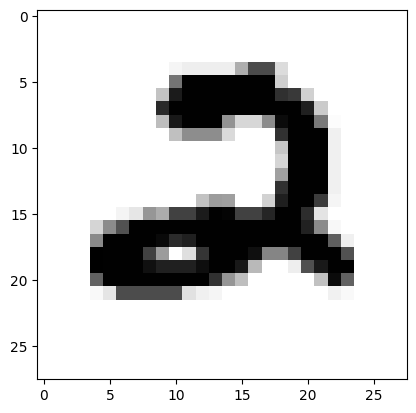

In [99]:
plt.imshow(x_test_normalized[0].reshape((IMAGE_WIDTH, IMAGE_HEIGHT)), cmap=plt.cm.binary)
plt.show()

**Submition**

In [100]:
test_pred = pd.DataFrame( loaded_model.predict([x_test_normalized]))
test_pred = pd.DataFrame(test_pred.idxmax(axis = 1))
test_pred.index.name = 'ImageId'
test_pred = test_pred.rename(columns = {0: 'Label'}).reset_index()
test_pred['ImageId'] = test_pred['ImageId'] + 1

test_pred.head()

875/875 [==============================] - 4s 5ms/step


,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [101]:
test_pred.to_csv('submission.csv', index = False)